In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

data = pd.read_csv("diabetes (2).csv")

X = data.drop(columns=['Diabetic'])
y = data['Diabetic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))  
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_reduced = {
    'preprocessor__num__pca__n_components': [3, 5],
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_search_reduced = GridSearchCV(
    pipeline, 
    param_grid_reduced, 
    scoring='f1', 
    cv=3, 
    n_jobs=-1,  
    verbose=1
)

grid_search_reduced.fit(X_train, y_train)

print("Najlepsze hiperparametry:", grid_search_reduced.best_params_)
print("Najlepszy wynik (F1-score):", grid_search_reduced.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Najlepsze hiperparametry: {'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'preprocessor__num__pca__n_components': 5}
Najlepszy wynik (F1-score): 0.6543964215923164


Wnioski : Dla stworzonego wcześniej Pipeline’a przeprowadzono optymalizację hiperparametrów za pomocą GridSearchCV z walidacją krzyżową (3-fold). Najlepsze ustawienia to C=0.1, solver=liblinear oraz 5 komponentów PCA, co dało najwyższy wynik F1-score = 0.6544, wskazując na optymalną równowagę między precyzją i czułością modelu. 

Porównuje wyniki modelu przed i po zastosowaniu GridSearchCV co pozwoli lepiej zrozumieć wpływ optymalizacji hiperparametrów na jakość modelu.

Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 **Wyniki dla modelu: Logistic Regression**
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2014
           1       0.73      0.56      0.64       986

    accuracy                           0.79      3000
   macro avg       0.77      0.73      0.74      3000
weighted avg       0.78      0.79      0.78      3000



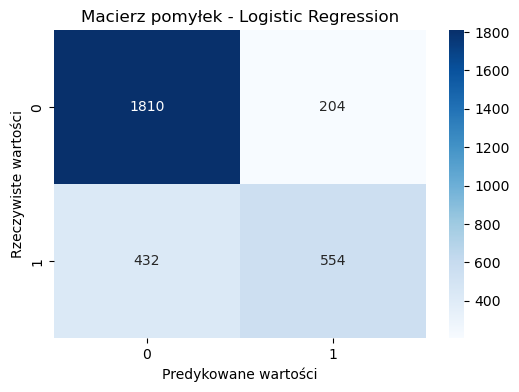

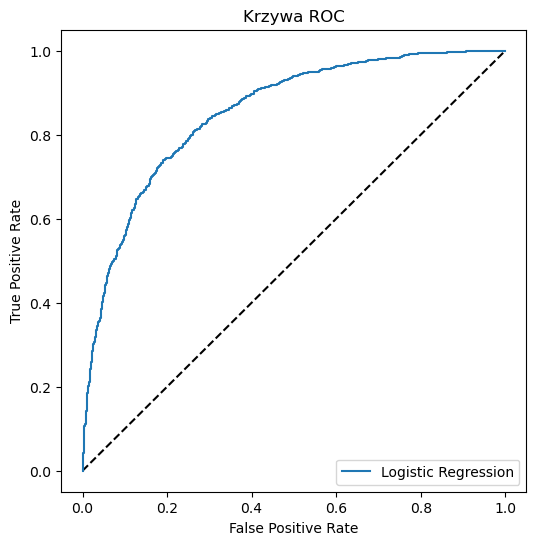


📊 **Wyniki dla modelu: Logistic Regression - standaryzacja i PCA**
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2014
           1       0.73      0.56      0.63       986

    accuracy                           0.79      3000
   macro avg       0.77      0.73      0.74      3000
weighted avg       0.78      0.79      0.78      3000



C:\Users\mnkku\AppData\Local\Temp\ipykernel_14568\1097043269.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_metrics], ignore_index=True)


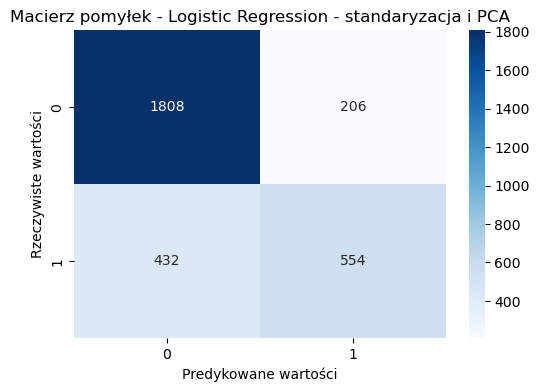

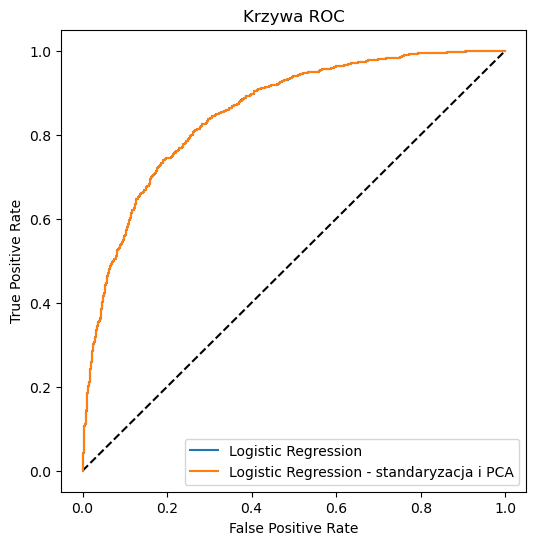


📊 Porównanie wyników przed i po optymalizacji:
Metryka              Przed optymalizacją  Po optymalizacji    
F1-score             0.6353               0.6346              
Accuracy             0.7900               0.7873              
AUC Score            0.8527               0.8527              

📊 Porównanie wyników modeli:


,Model,F1_score,AUC
0,Logistic Regression,0.635321,0.852745
1,Logistic Regression - standaryzacja i PCA,0.634593,0.852737


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, accuracy_score, roc_auc_score

# Wartości metryk przed optymalizacją
before_optimization = {
    "F1-score": 0.6353,
    "Accuracy": 0.79,
    "AUC Score": 0.8527
}

# Inicjalizacja list do przechowywania wyników
models = []
models_names = []
predictions_proba_list = []
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])

def calculate_metrics(model, name, X_checked, y_checked):
    
    global metrics_dataframe
    
    if not hasattr(model, "fit"):
        print(f" Model {name} nie został wytrenowany przed użyciem. Trenuję teraz...")
        model.fit(X_train, y_train)

    # Zapisanie modelu i jego nazwy
    models.append(model)
    models_names.append(name)

    # Predykcja klasy i prawdopodobieństw
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)[:, 1]
    predictions_proba_list.append(predictions_proba)

    # Wyświetlenie klasyfikacyjnego raportu
    print(f"\n📊 **Wyniki dla modelu: {name}**")
    print(classification_report(y_checked, predictions))

    # Macierz pomyłek
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_checked, predictions)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.title(f'Macierz pomyłek - {name}')
    plt.xlabel('Predykowane wartości')
    plt.ylabel('Rzeczywiste wartości')
    plt.show()

    # Wykres ROC
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, _ = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Krzywa ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Obliczenie metryk
    f1_metric = f1_score(y_checked, predictions)
    accuracy_metric = accuracy_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba)

    # Jeśli to model po optymalizacji, tworzymy porównanie
    if name == "Logistic Regression - standaryzacja i PCA":
        print("\n Porównanie wyników przed i po optymalizacji:")
        print(f"{'Metryka':<20} {'Przed optymalizacją':<20} {'Po optymalizacji':<20}")
        print("=" * 60)
        print(f"{'F1-score':<20} {before_optimization['F1-score']:<20.4f} {f1_metric:<20.4f}")
        print(f"{'Accuracy':<20} {before_optimization['Accuracy']:<20.4f} {accuracy_metric:<20.4f}")
        print(f"{'AUC Score':<20} {before_optimization['AUC Score']:<20.4f} {auc_metric:<20.4f}")
        print("=" * 60)

    # Dodanie wyników do DataFrame
    new_metrics = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_metrics], ignore_index=True)

    return metrics_dataframe
pipeline.fit(X_train, y_train)
grid_search_reduced.fit(X_train, y_train)
best_pipeline = grid_search_reduced.best_estimator_

# Model 1: Logistic Regression bez preprocessing
metrics_dataframe = calculate_metrics(pipeline, "Logistic Regression", X_test, y_test)

# Model 2: Logistic Regression ze standaryzacją i PCA (po optymalizacji)
metrics_dataframe = calculate_metrics(best_pipeline, "Logistic Regression - standaryzacja i PCA", X_test, y_test)

print("\n Porównanie wyników modeli:")
display(metrics_dataframe)

Wnioski - Macierze pomyłek i krzywe ROC dla modeli przed i po optymalizacji:

Przed optymalizacją:
    Model lepiej radził sobie z klasyfikacją klasy 0, ale miał trudności z wykrywaniem klasy 1 (False Negatives 
    = 432).
    Krzywa ROC wykazywała dobrą zdolność rozróżniania klas, ale nie idealną.
Po optymalizacji:
    Liczba błędnych klasyfikacji (FN i FP) pozostała praktycznie bez zmian.
    Optymalizacja hiperparametrów nie poprawiła skuteczności wykrywania klasy 1.
    
Wyniki te sugerują, że PCA mogło usunąć istotne informacje z danych, co wpłynęło na jakość modelu.

Wnioski: 

🔹 Optymalizacja hiperparametrów nie przyniosła żadnej poprawy, a wręcz w niektórych aspektach lekko pogorszyła wyniki.

🔹 Największy problem: Model nie poprawił wykrywalności klasy pozytywnej (1), co widać po braku zmian w F1-score i AUC.

🔹 PCA nie pomogło: Po dodaniu PCA wyniki są niemal identyczne, co oznacza, że redukcja wymiarowości nie miała pozytywnego wpływu na model.